In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os

from tensorflow import keras
from tensorflow.keras import layers, losses

#### Dataset

* 3,670 images

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_file = tf.keras.utils.get_file(origin=dataset_url, untar=True)
data_path = pathlib.Path(os.path.join(os.path.dirname(dataset_file), 'flower_photos'))

In [3]:
image_count = len(list(data_path.glob('*/*.jpg')))
print(image_count)

3670


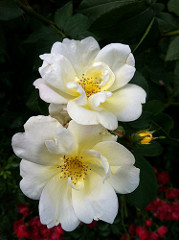

In [4]:
roses = list(data_path.glob('roses/*'))
PIL.Image.open(str(roses[0]))

#### Create a dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation')

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [9]:
class_names = train_dataset.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

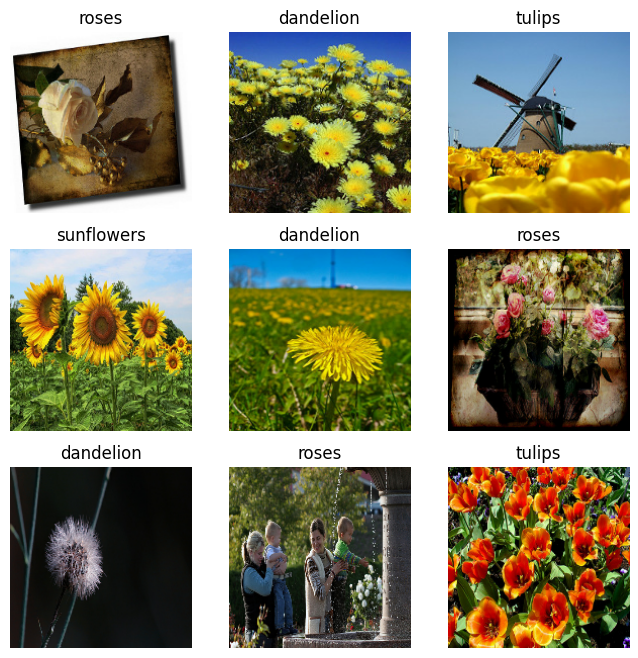

In [10]:
image_batch, labels_batch = next(iter(train_dataset))
image_batch = tf.cast(image_batch, tf.uint8)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i])
    plt.title(class_names[labels_batch[i]])
    plt.axis(False)

In [11]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


#### Configure the dataset for performance

* Using buffered prefetching, you can yield data from disk without having I/O become blocking.

In [12]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)

-1


#### Standardize the data


Approach using `map` and `lambda`

In [13]:
normalization_layer = layers.Rescaling(1/255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0161317 1.0


Approach adding layer to the model
```python
layers.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
```

#### Create Model

In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    layers.Rescaling(1/255, input_shape=(img_width, img_height, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

#### Compile the Model

In [15]:
def compile_model(model):
    model.compile(optimizer='adam',
                    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

compile_model(model)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Train the Model

In [17]:
def train_model(epochs):
    return model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

epochs=10
history = train_model(epochs)


Epoch 1/10
92/92 [==============================] - 7s 50ms/step - loss: 1.3210 - accuracy: 0.4469 - val_loss: 1.0432 - val_accuracy: 0.5913
Epoch 2/10
92/92 [==============================] - 3s 36ms/step - loss: 0.9870 - accuracy: 0.6080 - val_loss: 0.9490 - val_accuracy: 0.6403
Epoch 3/10
92/92 [==============================] - 3s 36ms/step - loss: 0.7871 - accuracy: 0.6945 - val_loss: 0.8734 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5832 - accuracy: 0.7769 - val_loss: 0.8855 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 3s 35ms/step - loss: 0.4102 - accuracy: 0.8621 - val_loss: 0.9316 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 3s 36ms/step - loss: 0.2416 - accuracy: 0.9183 - val_loss: 1.1206 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 3s 36ms/step - loss: 0.1494 - accuracy: 0.9540 - val_loss: 1.2110 - val_accuracy: 0.6444
Epoch 8/10
92

#### Visualize training results

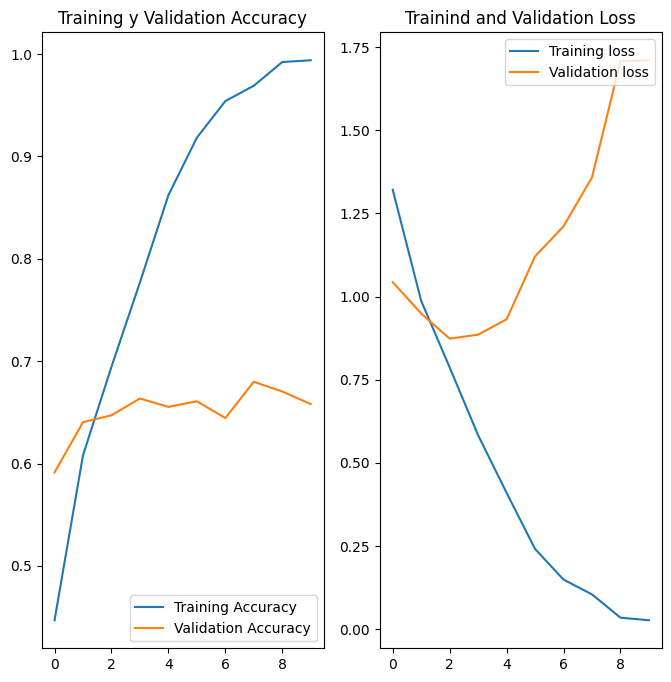

In [18]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training y Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(loc='upper right')
    plt.title('Trainind and Validation Loss')

plot_results(history)

#### Data Augmentation

In [19]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

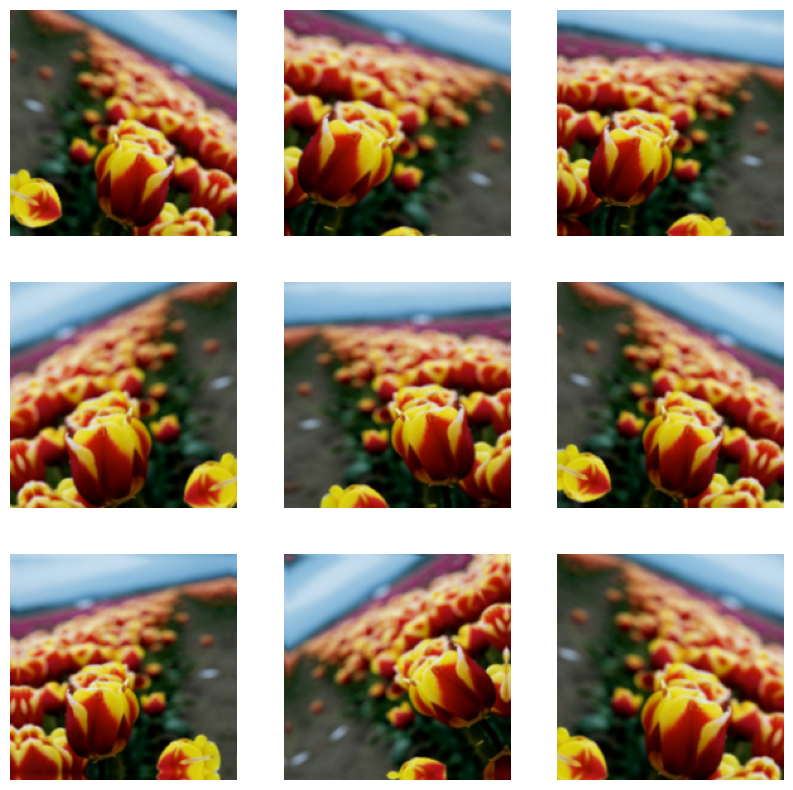

In [20]:
image_batch, _ = next(iter(train_dataset))
image = tf.expand_dims(image_batch[0], 0)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = tf.cast(data_augmentation(image)[0], tf.uint8)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis(False)


In [21]:
model = tf.keras.Sequential([
    data_augmentation,      # added
    layers.Rescaling(1/255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),    # added
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [22]:
compile_model(model)

In [23]:
epochs = 15
history = train_model(epochs)

Epoch 1/15
92/92 [==============================] - 9s 88ms/step - loss: 1.4176 - accuracy: 0.3941 - val_loss: 1.2045 - val_accuracy: 0.5232
Epoch 2/15
92/92 [==============================] - 8s 87ms/step - loss: 1.0679 - accuracy: 0.5746 - val_loss: 1.0748 - val_accuracy: 0.5708
Epoch 3/15
92/92 [==============================] - 9s 93ms/step - loss: 0.9581 - accuracy: 0.6250 - val_loss: 0.9954 - val_accuracy: 0.6022
Epoch 4/15
92/92 [==============================] - 9s 96ms/step - loss: 0.8915 - accuracy: 0.6543 - val_loss: 0.9028 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 9s 95ms/step - loss: 0.8203 - accuracy: 0.6921 - val_loss: 0.9472 - val_accuracy: 0.6349
Epoch 6/15
92/92 [==============================] - 9s 95ms/step - loss: 0.8002 - accuracy: 0.6989 - val_loss: 0.9057 - val_accuracy: 0.6362
Epoch 7/15
92/92 [==============================] - 9s 96ms/step - loss: 0.7677 - accuracy: 0.7033 - val_loss: 0.8199 - val_accuracy: 0.6812
Epoch 8/15
92

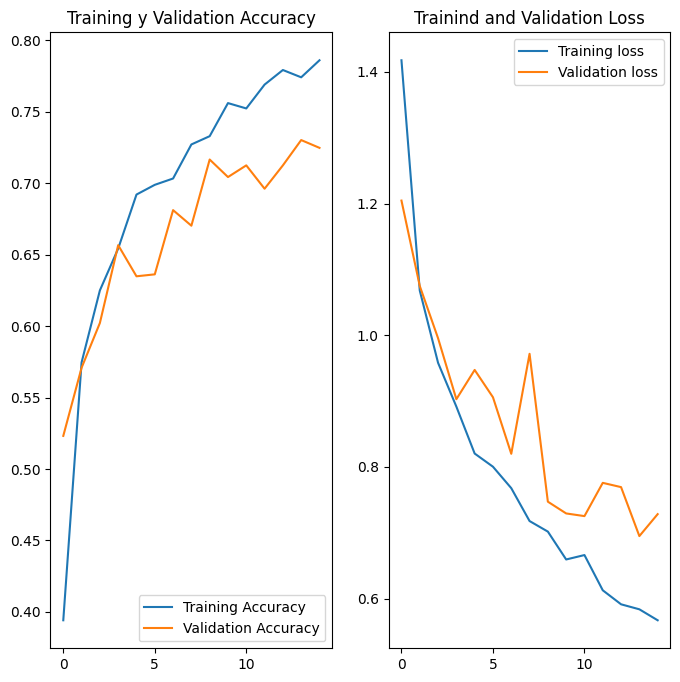

In [24]:
plot_results(history)

#### Predict on new data

In [25]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(f'This image most likely belongs to {class_names[np.argmax(score)]} with a {100*np.max(score):.2f} percent confidence.')


1/1 [==============================] - 0s 185ms/step
This image most likely belongs to sunflowers with a 90.28 percent confidence.
